In [1]:
import pandas as pd
import pickle
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import gc
%matplotlib inline

## load in data

In [2]:
path = './data/'
files = os.listdir(path)
player_stats_files = sorted([(int(re.sub('[^0-9]', '', f)), path + f)
                             for f in files if "player" in f], key=lambda x: x[0])
opp_stats_files = sorted([(int(re.sub('[^0-9]', '', f)), path + f)
                          for f in files if "opp" in f], key=lambda x: x[0])

player_dfs = {}
for year, fn in player_stats_files:
    df = pd.read_csv(fn, index_col=0)
    df['team'] = df['team'].str.replace('JAX','JAC')
    df['team'] = df['team'].str.replace('LAC','SD')
    df['year'] = year
    player_dfs[year] = df

opp_dfs = {}
for year, fn in opp_stats_files:
    df = pd.read_csv(fn, index_col=0)
    df['year'] = year
    df['opp_TEAM'] = df['opp_TEAM'].str.replace('JAX','JAC')
    df['opp_OPP'] = df['opp_OPP'].str.replace('JAX','JAC')
    df['opp_TEAM'] = df['opp_TEAM'].str.replace('LAC','SD')
    df['opp_OPP'] = df['opp_OPP'].str.replace('LAC','SD')
    opp_dfs[year] = df

new_opp_cols = ['offense', 'defense', 'opp_first_downs', 'opp_points',
       'opp_passing_yds', 'opp_penalty_cnt', 'opp_penalty_yds', 'opp_pos_time',
       'opp_punt_avg', 'opp_punt_cnt', 'opp_punt_yds', 'opp_rushing_yds',
       'opp_total_yds', 'opp_turnovers', 'week', 'year']

for year, df in opp_dfs.items():
    df.columns = new_opp_cols
    opp_dfs[year] = df

In [3]:
for year in range(2013,2018):
    print(player_dfs[year].shape)

(13827, 80)
(14124, 80)
(14151, 80)
(14149, 80)
(10592, 80)


In [4]:
## missing positions
# data = pd.concat(player_dfs.values())
# missing_positions = data[data.position.isnull()]
# means = missing_positions.groupby('profile_url', as_index=False).mean()
# means = means[['profile_url','passing_att', 'rushing_att', 'receiving_rec']]
# means.columns = ['profile_url','QB','RB','WRTE']
# means = means[(means.QB != 0) | (means.RB != 0) | (means.WRTE != 0)]
# missing_positions_urls = means.profile_url.unique().tolist()
# with open('data/missing_positions_urls.pkl', 'wb') as f:
#     pickle.dump(missing_positions_urls, f)

## clean data and create target variable

In [5]:
def clean(player_stats, year):
    player_stats['fantasy_points'] = (player_stats['passing_tds'] * 4) +\
    (player_stats['passing_yds'] * 0.04) +\
    (player_stats['passing_twoptm'] * 2) +\
    (player_stats['passing_ints'] * -2) +\
    (player_stats['rushing_tds'] * 6) +\
    (player_stats['rushing_yds'] * 0.1) +\
    (player_stats['rushing_twoptm'] * 2) +\
    (player_stats['receiving_tds'] * 6) +\
    (player_stats['receiving_yds'] * 0.1) +\
    (player_stats['receiving_twoptm'] * 2) +\
    (player_stats['kickret_tds'] * 6) +\
    (player_stats['puntret_tds'] * 6) +\
    (player_stats['fumbles_lost'] * -2)
    
    player_stats['passer_ratio'] = player_stats['passing_cmp']/player_stats['passing_att']
    player_stats['PassRushRatio_Att'] = player_stats['passing_att'] / player_stats['rushing_att']
    player_stats['PassRushRatio_Yds'] = player_stats['passing_yds'] / player_stats['rushing_yds']
    player_stats['PassRushRatio_Tds'] = player_stats['passing_tds'] / player_stats['rushing_tds']
    player_stats['RushRecRatio_AttRec'] = player_stats['rushing_att'] / player_stats['receiving_rec']
    player_stats['RushRecRatio_Tds'] = player_stats['rushing_tds'] / player_stats['receiving_tds']
    player_stats['RushRecRatio_Yds'] = player_stats['rushing_yds'] / player_stats['receiving_yds']
 
    include_positions = ['QB', 'TE', 'WR', 'RB']
    player_stats['position'] = player_stats['position'].str.replace('FB','RB')
    player_stats = player_stats[player_stats['position'].isin(include_positions)]
    return player_stats

player_dfs = {year:clean(df, year) for year, df in player_dfs.items()}

## feature engineering

In [6]:
kick_stats = ['kicking_fga', 'kicking_fgm',
       'kicking_fgyds', 'kicking_totpfg', 'kicking_xpa', 'kicking_xpb',
       'kicking_xpmade', 'kicking_xpmissed', 'kicking_xptot', 'kickret_avg',
       'kickret_lng', 'kickret_lngtd', 'kickret_ret', 'kickret_tds',
       'punting_avg', 'punting_i20', 'punting_lng', 'punting_pts',
       'punting_yds']

stat_cols = ['fumbles_lost', 'fumbles_rcv', 'fumbles_tot','fumbles_trcv', 'fumbles_yds', 
       'passing_att', 'passing_cmp', 'passing_ints', 'passing_tds', 'passer_ratio',
       'passing_twopta', 'passing_twoptm', 'passing_yds',
       'puntret_tds','puntret_avg', 'puntret_lng', 'puntret_lngtd', 'puntret_ret',
       'receiving_lng', 'receiving_lngtd','receiving_rec', 'receiving_tds', 'receiving_twopta',
       'receiving_twoptm', 'receiving_yds', 'rushing_att', 'rushing_lng',
       'rushing_lngtd', 'rushing_tds', 'rushing_twopta', 'rushing_twoptm',
       'rushing_yds','fantasy_points',
        'PassRushRatio_Att','PassRushRatio_Yds','PassRushRatio_Tds','RushRecRatio_AttRec',
        'RushRecRatio_Tds','RushRecRatio_Yds']

### Intra-season player stats

In [7]:
def trim_sort(df):
    df = df.sort_values(['id','week'])
    df = df[stat_cols+['id','week','team','position','full_name']]
    return df

def get_trend(df):
    # compute 3-week and 2-week points deltas
    deltas = df.groupby(['id']).pct_change()
    deltas = deltas.add_prefix('chg_')
    deltas = pd.concat([df, deltas], axis=1)
    deltas2 = deltas.groupby(['id'])[deltas.columns].shift(1).fillna(0)
    deltas3 = deltas.groupby(['id'])[deltas.columns].shift(2).fillna(0)
    deltas2 = deltas2.add_prefix('per2_')
    deltas3 = deltas3.add_prefix('per3_')
    trend_df = pd.concat([deltas, deltas2, deltas3], axis=1)
    # average prior three deltas to get trend
    for col in stat_cols:
        name = 'trend_'+col
        trend_df[name] = trend_df[['chg_'+col,'per2_chg_'+col,'per3_chg_'+col]].mean(axis=1).fillna(0)
    return trend_df

def get_cumul_mean_stats(df, weeks):
    weeks_stats_mean = []
    for week in weeks:
        tmp = df[df.week <= week]
        tmp = tmp.groupby(['id'])[stat_cols].mean().reset_index()
        tmp = tmp.add_suffix('_mean')
        tmp['week'] = week
        weeks_stats_mean.append(tmp)
    cumavg_stats = pd.concat(weeks_stats_mean)
    cumavg_stats = cumavg_stats.rename(columns={'id_mean':'id'})
    return cumavg_stats

def get_cumul_stats_time_weighted(df, weeks):
    weeks_stats_mean_wgt = []
    for week in weeks:
        tmp1 = df[df.week <= week]
        mult = lambda x: np.asarray(x) * np.asarray(tmp1.week)
        tmp = tmp1[['id']+stat_cols].set_index('id').apply(mult).reset_index()
        tmp = tmp.groupby(['id'])[stat_cols].mean().reset_index()
        tmp = tmp.add_suffix('_wgtmean')
        tmp['week'] = week
        weeks_stats_mean_wgt.append(tmp)
    cumavg_stats_wgt = pd.concat(weeks_stats_mean_wgt)
    cumavg_stats_wgt = cumavg_stats_wgt.rename(columns={'id_wgtmean':'id'})
    return cumavg_stats_wgt

def defensive_ptsallow(matchups, weeks, weighted=False):
    agg_col = 'fantasy_points'
    output_name = 'defensive_matchup_allowed'
    if weighted:
        agg_col = 'weighted_fantasy_points'
        output_name = 'defensive_matchup_allowed_wgt'
    # compute weekly cumulative mean points allowed by each defense
    defense_ranks_dfs = []
    for week in weeks:
        matchweek = matchups[matchups.week <= week]
        # weekly sum of pts allowed by a given defense to each position
        weekly_sums = matchweek.groupby(['week','defense','position'])[agg_col].sum().reset_index()
        # STD mean of weekly sums for each position
        defense_pts_allowed = weekly_sums.groupby(['defense','position'])[agg_col].mean().reset_index()
        defense_pts_allowed = defense_pts_allowed.rename(columns={agg_col:output_name})
        defense_pts_allowed['week'] = week
        defense_ranks_dfs.append(defense_pts_allowed)
    defense_ranks = pd.concat(defense_ranks_dfs)
    return defense_ranks

def weekly_player_weights(matchups, weeks):
    # Calculate season-to-date (STD) weekly fantasy points rankings by position 
    player_weights = []
    for week in weeks:
        mask = (matchups.week <= week)
        # each player's mean fantasy points STD
        std_mean = matchups[mask][['id','team','position','fantasy_points','defense']]
        std_mean = std_mean.groupby(['position','id'], as_index=False).mean()

        # each player's weight in a given week with respect to their position
        week_max_position = std_mean.groupby('position', as_index=False).max()
        week_max_position = week_max_position[['position','fantasy_points']]
        week_max_position.columns = ['position','fp_max']
        weekly_weights = std_mean.merge(week_max_position,how='left',on='position')
        weekly_weights['player_weight'] = weekly_weights['fantasy_points'] / weekly_weights['fp_max']
        weekly_weights['week'] = week
        player_weights.append(weekly_weights)
    player_weights = pd.concat(player_weights)
    return player_weights[['id','week','position','player_weight']]

def create_nfl_features(player_stats_orig, opp_stats_orig):
    player_stats_trimmed = trim_sort(player_stats_orig)
    weeks = sorted(player_stats_trimmed.week.unique().tolist())

    # offensive player stats
    trend_df         = get_trend(player_stats_trimmed)
    cumavg_stats     = get_cumul_mean_stats(player_stats_trimmed, weeks)
    cumavg_stats_wgt = get_cumul_stats_time_weighted(player_stats_trimmed, weeks)

    # defensive opponent stats
    matchup_cols = ['id', 'week', 'team','position', 'full_name', 'offense', 'defense','fantasy_points']
    sched             = opp_stats_orig[['offense','defense','week']]
    matchups          = player_stats_trimmed.merge(sched,how='left',
                                           left_on=['week','team'],
                                           right_on=['week','offense'])[matchup_cols]
    defense_ranks     = defensive_ptsallow(matchups, weeks)
    player_weights    = weekly_player_weights(matchups, weeks)
    player_weights['inverse'] = 1/player_weights.player_weight
    matchups_wgts     = matchups.merge(player_weights, how='left', on=['id','week','position'])
    matchups_wgts['weighted_fantasy_points'] = matchups_wgts['fantasy_points'] * matchups_wgts['inverse']
    defense_ranks_wgt = defensive_ptsallow(matchups_wgts, weeks, weighted=True)
    
    ## merge features

    # shift target, week, and defensive opponent
    matchups['target_defense'] = matchups.sort_values(['id','week']).groupby('id')['defense'].shift(-1)
    matchups['target'] = matchups.sort_values(['id','week']).groupby('id')['fantasy_points'].shift(-1)
    matchups['target_week'] = matchups.sort_values(['id','week']).groupby('id')['week'].shift(-1)

    # drop week 1 and current week
    matchups.dropna(inplace=True)

   # fill in zeros for players with missing historical stats
    matchups.fillna(0, inplace=True)

    # merge player weights to player stats
    matchups = matchups.merge(player_weights, on=['id','week','position'])

    # merge defense rankings to player stats
    defense_ranks_all = defense_ranks.merge(defense_ranks_wgt, on=['defense', 'position', 'week'])
    defense_ranks_all = defense_ranks_all.rename(columns={'defense':'target_defense'})
    matchups = matchups.merge(defense_ranks_all, how='left', on=['target_defense','position','week']).dropna()

    # merge intraseason trend, average, and weighted avg points
    avgs = cumavg_stats.merge(cumavg_stats_wgt,how='inner',on=['id','week'])
    matchups = matchups.merge(avgs, how='left', on=['id','week'])
    trend_cols = ['id','week']+[col for col in trend_df if col not in matchups.columns]
    td = trend_df[trend_cols]
    matchups = matchups.merge(td, how='inner', on=['id','week'])
    for col in trend_df.columns:
        matchups[col].fillna(0, inplace=True)

    # create extra player attributes and merge to make model-ready df
    attribs = ['id','birthdate','years_pro','height','weight','position','profile_url','last_name','number']
    player_attributes = player_stats_orig[attribs]
    player_attributes.drop_duplicates(['id'],inplace=True)
    from datetime import datetime
    player_attributes['birthdate'] = pd.to_datetime(player_attributes['birthdate'])
    player_attributes['age'] = player_attributes['birthdate'].apply(lambda x: (datetime.today() - x).days/365)
    position_dummies = pd.get_dummies(player_attributes['position'])
    player_attributes = pd.concat([position_dummies, player_attributes], axis=1).drop(['position'],axis=1)

    # final cleaning
    model_df = player_attributes.merge(matchups, how='right',on='id')
    model_df.replace([-np.inf,np.inf], 0, inplace=True)
    return model_df

In [8]:
nfl_dfs = {year:create_nfl_features(df, opp_dfs[year]) 
                         for year, df in player_dfs.items()}

/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:145: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/ipykernel/__main__.py:146: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

## merge DFS salaries

In [9]:
path = './data/FanDuel/'
files = os.listdir(path)
fanduel_dfs = {}
for fn in files:
    yr = int(re.sub('[^0-9]', '', fn))
    fanduel_dfs[yr] = pd.read_csv(path+fn)

In [10]:
def clean_salaries(df, service, year):
    positions = ['QB', 'RB', 'WR', 'TE']
    df['FirstName'] = df['FirstName'].str.strip()
    df['LastName'] = df['LastName'].str.strip()
    df['full_name'] = df['LastName']+' '+df['FirstName']
    df = df[df.Pos.isin(positions)].fillna(0)[['Week','Team','full_name',service+'_points',service+'_salary']]
    df.columns = ['week','team','full_name',service+'_points',service+'_salary']
    df['team'] = df['team'].str.upper()
    df['team'] = df['team'].str.replace('KAN','KC')
    df['team'] = df['team'].str.replace('GNB','GB')
    df['team'] = df['team'].str.replace('LAR','LA')
    df['team'] = df['team'].str.replace('TAM','TB')
    df['team'] = df['team'].str.replace('SFO','SF')
    df['team'] = df['team'].str.replace('NOR','NO')
    df['team'] = df['team'].str.replace('NWE','NE')
    df['team'] = df['team'].str.replace('SDG','SD')
    df['team'] = df['team'].str.replace('LAC','SD')
    return df

def merge_salaries(players, salaries):
    new_players = {}
    for year in players.keys():
        players_year = players[year]
        salaries_year = clean_salaries(salaries[year], 'fd', year)
        players_teams = set(players_year.team)
        salaries_teams = set(salaries_year.team)
        print(year, salaries_teams ^ players_teams)
        salary_merge = players_year.merge(salaries_year,how='left',on=['week','full_name','team'])
        new_players[year] = salary_merge.fillna(0)
    return new_players

In [11]:
nfl_fanduel_dfs = merge_salaries(nfl_dfs, fanduel_dfs)

2016 set()
2017 set()
2013 set()
2014 set()
2015 set()


In [12]:
def add_year(df, yr):
    df['year'] = yr
    return df

for year in nfl_fanduel_dfs.keys():
    df_year = nfl_fanduel_dfs[year]
    nfl_fanduel_dfs[year] = add_year(df_year, year)

## snap counts

In [13]:
def merge_snap_counts(dfs):
    path = './data/FO_data/SnapCounts/'
    SC_files = os.listdir(path)

    SC_dfs = []
    for fn in SC_files:
        week = int(fn[:2])
        year = int(fn[3:7])
        df = pd.read_csv(path+fn)
        df['week'] = week
        df['year'] = year
        SC_dfs.append(df)
    sc = pd.concat(SC_dfs)

    sc['number'] = pd.to_numeric(sc.Player.str.replace('[^0-9]',''))
    sc['last_name'] = sc.Player.str.replace('[A-Za-z\s]+\.','')
    sc['last_name'] = sc.last_name.str.replace('[^A-Za-z\s]','').str.strip()
    sc['started'] = sc['Started'].apply(lambda x: 1 if x=='YES' else 0)
    sc['offensive_snap_pct'] = pd.to_numeric(sc['Off Snap Pct'].str.replace('[^0-9]',''), 
                                             downcast='float')
    sc['offensive_snap_tot'] = sc['Off Snaps']
    sc['position'] = sc.Position.str.replace('FB','RB').str.strip()
    sc['team'] = sc['Team'].str.replace('LARM/STL','LA')
    sc['team'] = sc['team'].str.replace('LAR','LA')
    sc['team'] = sc['team'].str.replace('LAC','SD').str.strip()

    sc = sc[sc.position.isin(['QB','RB','WR','TE'])]
    sc = sc[['number','last_name','started','offensive_snap_pct',
             'offensive_snap_tot','position','team','week','year']]
    new_dfs = {}
    for year, df in dfs.items():
        merge_df = df.merge(sc, on=['last_name','team','week','year','position'])
        new_dfs[year] = merge_df
    return new_dfs

In [14]:
nfl_fd_sc_dfs = merge_snap_counts(nfl_fanduel_dfs)

## gameday weather

In [15]:
def merge_weather(dfs):
    from data.nfl_teams import team_dict
    path = './data/NflWeather/'
    weather_files = os.listdir(path)
    weather_dfs = []
    for fn in weather_files:
        week = re.findall('_[0-9]+\.',fn)
        week = re.sub('[^0-9]','',str(week))
        year = fn[:4]
        df = pd.read_csv(path+fn)
        df['week'] = int(week)
        df['year'] = int(year)
        weather_dfs.append(df)
    weather = pd.concat(weather_dfs)

    weather['team1'] = weather['team1'].apply(lambda x: team_dict[x])
    weather['team2'] = weather['team2'].apply(lambda x: team_dict[x])

    weather['wind_conditions'] = pd.to_numeric(weather['wind_conditions'].str.replace('[^0-9]',''))
    weather['indoor_outdoor'] = weather['weather_forecast'].apply(lambda x: 1 if 'DOME' in x else 0)

    weather1 = weather[['team1','wind_conditions','indoor_outdoor','week','year']]
    weather1.columns = ['team','wind_conditions','indoor_outdoor','week','year']
    weather2 = weather[['team2','wind_conditions','indoor_outdoor','week','year']]
    weather2.columns = ['team','wind_conditions','indoor_outdoor','week','year']
    weather = pd.concat([weather1,weather2])
    
    new_dfs = {}
    for year, df in dfs.items():
        merge_df = df.merge(weather,on=['team','week','year'])
        new_dfs[year] = merge_df
    return new_dfs

In [16]:
nfl_fd_sc_weather_dfs = merge_weather(nfl_fd_sc_dfs)

## holdout and train sets

In [17]:
for year in range(2013,2018):
    print(nfl_fd_sc_weather_dfs[year].shape)

(1849, 397)
(2607, 397)
(3203, 397)
(3582, 397)
(3145, 397)


In [18]:
max_year = max(list(nfl_fd_sc_weather_dfs.keys()))
holdout = nfl_fd_sc_weather_dfs[2017]
model_dfs = [nfl_fd_sc_weather_dfs[yr] for yr in nfl_fd_sc_weather_dfs.keys() if yr != max_year]
model_df = pd.concat(model_dfs)

In [19]:
model_df.isnull().values.any()

False

In [20]:
holdout.isnull().values.any()

False

In [21]:
model_df.shape

(11241, 397)

In [22]:
holdout.shape

(3145, 397)

## boxcox transform target

In [98]:
from scipy.stats import boxcox
model_df.reset_index(inplace=True, drop=True)
model_df['target_transform'] = model_df.target - (model_df.target.min()-1)
model_df['target_boxcox'] = pd.Series(boxcox(model_df.target_transform)[0])
model_df['target_boxcox'].describe()

count    11241.000000
mean         1.572879
std          0.166410
min          0.000000
25%          1.427460
50%          1.564940
75%          1.710140
max          1.995948
Name: target_boxcox, dtype: float64

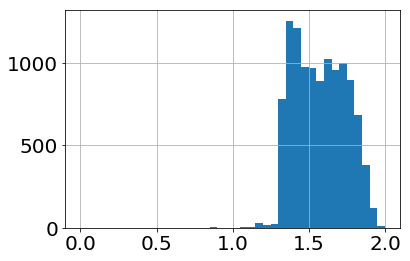

In [99]:
model_df['target_boxcox'].hist(bins=40)

In [111]:
model_df[(model_df.target_boxcox == np.inf) | (model_df.target_boxcox == -np.inf)].shape

(0, 400)

## convert target to target rank

In [29]:
model_df.sort_values(['year','position','week','target'], ascending=False, inplace=True)

In [30]:
model_df['target_rank'] = model_df.groupby(['year','position','week'])['target'].\
                                    rank(method="dense", ascending=False)

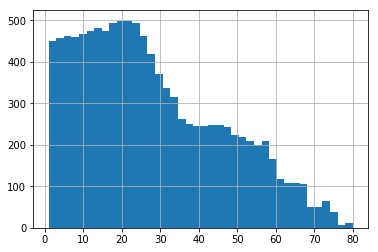

In [31]:
model_df['target_rank'].hist(bins=40)

## trim outliers

In [112]:
model_df.shape

(11241, 400)

(10166, 400)


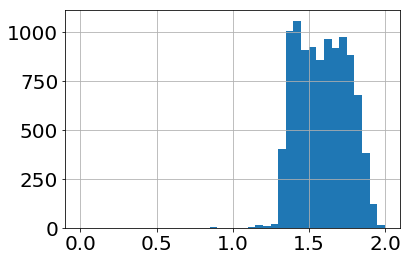

In [113]:
thresh = 1
tmp = model_df[model_df.fantasy_points_mean > thresh]
print(tmp.shape)
tmp.target_boxcox.hist(bins=40)

In [114]:
model_df_trimmed = model_df[model_df.fantasy_points_mean > thresh]
# model_df_trimmed['target_boxcox'] = pd.Series(boxcox(model_df_trimmed.target_transform)[0])

## player stat interactions

In [115]:
numeric_df_columns = model_df_trimmed.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns
fumble_features = [c for c in numeric_df_columns if "fumble" in c and "per" not in c]

passing_features = ['passing_att_mean','passing_cmp_mean','passing_ints_mean','passing_yds_mean',
                    'passing_tds_mean','passer_ratio','rushing_yds_mean','rushing_att_mean','rushing_tds_mean',
                    'PassRushRatio_Att_mean','PassRushRatio_Yds_mean', 'PassRushRatio_Tds_mean']

rushing_features = ['rushing_yds_mean','rushing_att_mean','rushing_tds_mean',
                    'RushRecRatio_AttRec_mean','RushRecRatio_Tds_mean','RushRecRatio_Yds_mean']

receiving_features = ['receiving_rec_mean','receiving_tds_mean','receiving_yds_mean']

sharedfeats = ['years_pro','age','weight','height','player_weight','year','week','team','target','target_rank',
               'target_boxcox','fantasy_points_mean','target_week','defensive_matchup_allowed','offensive_snap_pct',
               'offensive_snap_tot','fd_salary','started','wind_conditions','indoor_outdoor']+fumble_features

QB_features = sharedfeats+passing_features+rushing_features
RB_features = sharedfeats+rushing_features+receiving_features
WR_features = sharedfeats+receiving_features
TE_features = sharedfeats+receiving_features

In [116]:
QB_df = model_df_trimmed[model_df_trimmed.position == 'QB'][QB_features].reset_index().drop('index',axis=1)
QB_stats = QB_df.groupby(['year','week','team']).mean()[passing_features].reset_index().add_prefix('QBMEAN')
QB_stats=QB_stats.rename(columns={'QBMEANyear':'year', 'QBMEANweek':'week', 'QBMEANteam':'team'})
QB_merge_stats = ['QBMEANPassRushRatio_Att','QBMEANPassRushRatio_Yds','QBMEANPassRushRatio_Tds']

RB_df = model_df_trimmed[model_df_trimmed.position == 'RB'][RB_features].reset_index().drop('index',axis=1)
RB_stats = RB_df.groupby(['year','week','team']).mean()[rushing_features].reset_index().add_prefix('RBMEAN')
RB_stats=RB_stats.rename(columns={'RBMEANyear':'year', 'RBMEANweek':'week', 'RBMEANteam':'team'})

WR_df = model_df_trimmed[model_df_trimmed.position == 'WR'][WR_features].reset_index().drop('index',axis=1)
WR_stats = WR_df.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('WRMEAN')
WR_stats=WR_stats.rename(columns={'WRMEANyear':'year', 'WRMEANweek':'week', 'WRMEANteam':'team'})

TE_df = model_df_trimmed[model_df_trimmed.position == 'TE'][TE_features].reset_index().drop('index',axis=1)
TE_stats = TE_df.groupby(['year','week','team']).mean()[receiving_features].reset_index().add_prefix('TEMEAN')
TE_stats=TE_stats.rename(columns={'TEMEANyear':'year', 'TEMEANweek':'week', 'TEMEANteam':'team'})

In [117]:
print("QB:", QB_df.shape)
print("RB:", RB_df.shape)
print("WR:", WR_df.shape)
print("TE:", TE_df.shape)

QB: (1452, 63)
RB: (2910, 54)
WR: (4030, 48)
TE: (1774, 48)


In [118]:
QB_df = QB_df.merge(RB_stats, how='inner', on=['year','week','team'])

RB_df = RB_df.merge(QB_stats, how='inner', on=['year','week','team'])

WR_df = WR_df.merge(RB_stats, how='inner', on=['year','week','team'])
WR_df = WR_df.merge(QB_stats, how='inner', on=['year','week','team'])

TE_df = TE_df.merge(QB_stats, how='inner', on=['year','week','team'])
TE_df = TE_df.merge(RB_stats, how='inner', on=['year','week','team'])

In [119]:
print("QB:", QB_df.shape)
print("RB:", RB_df.shape)
print("WR:", WR_df.shape)
print("TE:", TE_df.shape)

QB: (1321, 69)
RB: (2588, 69)
WR: (3348, 69)
TE: (1453, 69)


## interactions by position

In [150]:
# from sklearn.preprocessing import PolynomialFeatures
# create_interactions = [('QB',QB_df), ('RB',RB_df), ('WR',WR_df), ('TE',TE_df)]
# interactions_positions = {}
# for pos, data in create_interactions:
#     numerics = data.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
#     data = data[numerics]
#     poly = PolynomialFeatures(2, interaction_only=True, include_bias=True)
#     interactions_arr = poly.fit_transform(data)
#     interactions_names = poly.get_feature_names(data.columns)
#     interactions = pd.DataFrame(interactions_arr, columns=interactions_names)
#     interactions_positions[pos] = interactions

# def explore_interaction_corrs(pos, interactions):
#     target_col = interactions.target_rank
#     nontarget_interactions = interactions[[c for c in interactions.columns if "target" not in c]]
#     explore = pd.concat([target_col, nontarget_interactions], axis=1)
#     corr_interactions = explore.corr()
#     return corr_interactions[['target_rank']].sort_values('target_rank',ascending=False).reset_index()

# QB_inters = explore_interaction_corrs('QB', interactions_positions['QB'])
# RB_inters = explore_interaction_corrs('RB', interactions_positions['RB'])
# WR_inters = explore_interaction_corrs('WR', interactions_positions['WR'])
# TE_inters = explore_interaction_corrs('TE', interactions_positions['TE'])

# QB_inters.to_csv('data/interactions_QB.csv')
# RB_inters.to_csv('data/interactions_RB.csv')
# WR_inters.to_csv('data/interactions_WR.csv')
# TE_inters.to_csv('data/interactions_TE.csv')

# QB_inters = pd.read_csv('data/interactions_QB.csv')
# RB_inters = pd.read_csv('data/interactions_RB.csv')
# WR_inters = pd.read_csv('data/interactions_WR.csv')
# TE_inters = pd.read_csv('data/interactions_TE.csv')

### QB

In [160]:
QB_inters.sort_values('target_rank',ascending=True).head(10)

,index,target_rank
4883,age player_weight,-0.257128
4882,player_weight,-0.252991
4881,player_weight year,-0.252731
4880,age fantasy_points_mean,-0.252125
4879,weight player_weight,-0.248991
4878,height player_weight,-0.248006
4877,player_weight started,-0.246212
4876,fantasy_points_mean,-0.246201
4875,year fantasy_points_mean,-0.245895
4874,weight fantasy_points_mean,-0.241363


### RB

In [167]:
RB_inters.sort_values('target_rank',ascending=True).head(15)

,index,target_rank
5383,rushing_att_mean,-0.506707
5382,year rushing_att_mean,-0.506565
5381,height rushing_att_mean,-0.505651
5380,age rushing_att_mean,-0.505518
5379,weight rushing_att_mean,-0.501533
5378,age rushing_yds_mean,-0.498788
5377,player_weight,-0.497595
5376,player_weight year,-0.497454
5375,rushing_yds_mean,-0.496762
5374,height rushing_yds_mean,-0.496647


### WR

In [171]:
WR_inters.sort_values('target_rank',ascending=False).head(15)

,index,target_rank
0,target_rank,1.000000
1,year,0.258507
2,chg_fumbles_tot receiving_yds_mean,0.097665
3,fantasy_points_mean chg_fumbles_tot,0.094086
4,player_weight chg_fumbles_tot,0.093083
5,chg_fumbles_tot receiving_rec_mean,0.092946
6,offensive_snap_pct chg_fumbles_tot,0.088527
15,RBMEANrushing_tds_mean QBMEANrushing_tds_mean,0.084675
22,RBMEANrushing_tds_mean QBMEANrushing_tds_mean,0.084675
21,RBMEANrushing_tds_mean QBMEANrushing_tds_mean,0.084675


### TE

In [174]:
TE_inters.sort_values('target_rank',ascending=True).head(10)

,index,target_rank
5314,age receiving_yds_mean,-0.392824
5313,height receiving_yds_mean,-0.392418
5312,receiving_yds_mean,-0.392030
5311,year receiving_yds_mean,-0.391884
5310,weight receiving_yds_mean,-0.389847
5309,offensive_snap_tot receiving_yds_mean,-0.389778
5308,height receiving_rec_mean,-0.386830
5307,receiving_rec_mean,-0.386028
5306,year receiving_rec_mean,-0.385845
5305,age receiving_rec_mean,-0.384072


## compute interactions

In [177]:
QB_df.reset_index(inplace=True,drop=True)
RB_df.reset_index(inplace=True,drop=True)
WR_df.reset_index(inplace=True,drop=True)
TE_df.reset_index(inplace=True,drop=True)

In [180]:
QB_df['chg_fumbles_yds trend_fumbles_tot'] = QB_df['trend_fumbles_tot']*QB_df['chg_fumbles_yds']
QB_df['age player_weight'] = QB_df['age']*QB_df['player_weight']
RB_df['player_weight offensive_snap_pct'] = RB_df['player_weight']*RB_df['offensive_snap_pct']
RB_df['fantasy_points_mean offensive_snap_tot'] = RB_df['offensive_snap_tot']*RB_df['fantasy_points_mean']
RB_df['offensive_snap_tot chg_fumbles_tot'] = RB_df['offensive_snap_tot']*RB_df['chg_fumbles_tot']
WR_df['chg_fumbles_tot receiving_yds_mean'] = WR_df['chg_fumbles_tot']*WR_df['receiving_yds_mean']
WR_df['age receiving_yds_mean'] = WR_df['age']*WR_df['receiving_yds_mean']
# WR_df['QBMEANrushing_tds_mean RBMEANrushing_tds_mean'] = WR_df['QBMEANrushing_tds_mean']*WR_df['RBMEANrushing_tds_mean']
TE_df['trend_fumbles_tot RBMEANRushRecRatio_AttRec_mean'] = TE_df['trend_fumbles_tot']*TE_df['RBMEANRushRecRatio_AttRec_mean']
TE_df['age receiving_yds_mean'] = TE_df['age']*TE_df['receiving_yds_mean']

## memory mgmt

In [186]:
# del player_dfs
# del opp_dfs
# del nfl_dfs
# del fanduel_dfs
# del nfl_fanduel_dfs
# del nfl_fd_sc_dfs
# del nfl_fd_sc_weather_dfs
# del QB_inters
# del RB_inters
# del WR_inters
# del TE_inters
# del interactions_positions
gc.collect()

5836

## model

In [48]:
import sklearn.metrics as metrics
import sklearn.linear_model as lin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
# from xgb import XGBRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from pprint import pprint
import matplotlib
import pickle

In [187]:
# weeks = sorted(model_df.target_week.unique().tolist())
# weeks.remove(1.0)
# weeks.remove(2.0)
weeks = list(range(2,14))

In [191]:
def regression_tts(input_df, week=13):
    input_df.sort_values('week', inplace=True)        
    features = input_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    features.remove('year')
    features.remove('target')
    features.remove('target_rank')
    features.remove('target_boxcox')

#     est = SVR(kernel='linear',C=10)
#     est = GradientBoostingRegressor(n_estimators=20, learning_rate=0.1)
#     est = RandomForestRegressor(n_estimators=10)
    est = lin.LassoCV()

    df_train = input_df[input_df.target_week < week]
    df_test = input_df[input_df.target_week == week]
#     print("Train size:",df_train.shape)
#     print("Test  size:",df_test.shape)

    X_train = df_train[features]
    y_train = df_train['target_rank']
    X_test = df_test[features]
    y_test = df_test['target_rank']

    ss = StandardScaler()
    X_train = ss.fit_transform(X_train)
    X_test = ss.fit_transform(X_test)

    est.fit(X_train,y_train)

    y_pred = est.predict(X_train)
#     train_mse = (metrics.mean_squared_error(y_train, y_pred))**(0.5)
    train_mse = metrics.r2_score(y_train, y_pred)

    y_pred = est.predict(X_test)
#     test_mse = (metrics.mean_squared_error(y_test, y_pred))**(0.5)
    test_mse = metrics.r2_score(y_test, y_pred)
    
    df_test = df_test.reset_index()[['target_week','target_rank']]
    df_test['MODEL_PRED'] = pd.Series(y_pred)
    df_test['RESIDUALS'] = df_test['MODEL_PRED'] - df_test['target_rank']
    
    coefs = None
    if 'sklearn.linear_model' in est.__module__:
        coef_ranks = list(zip(abs(est.coef_), est.coef_, features))
        coefs = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
    else:
        coef_ranks = list(zip(est.feature_importances_, features))
        coefs = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
        
    return test_mse, train_mse, est, coefs, df_test

In [192]:
coefs_all = {}
ests_positions = {}
resids_positions = []

for pos, data in [('QB',QB_df),('RB',RB_df),('WR',WR_df),('TE',TE_df)]:
    print(pos)
    mses_test, mses_train, est, coefs, resids = regression_tts(data)
    
    print('train r2:',mses_train)
    print('test  r2:',mses_test)
    coefs_all[pos] = coefs
    ests_positions[pos] = est
    resids['position'] = pos
    resids_positions.append(resids)

QB


/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


train r2: 0.0971708581343
test  r2: 0.143580942448
RB


/home/rjh336/anaconda2/envs/metis/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


train r2: 0.355036147471
test  r2: 0.389097720543
WR
train r2: 0.214348133224
test  r2: 0.253348170373
TE
train r2: 0.205358698623
test  r2: 0.18536498001


In [189]:
coefs_all = {}
ests_positions = {}
resids_positions = []

for pos, data in [('QB',QB_df),('RB',RB_df),('WR',WR_df),('TE',TE_df)]:
    print(pos)
    mses_test, mses_train, est, coefs, resids = regression_tts(data)
    
    print('train r2:',mses_train)
    print('test  r2:',mses_test)
    coefs_all[pos] = coefs
    ests_positions[pos] = est
    resids['position'] = pos
    resids_positions.append(resids)

QB
train r2: 0.231531602059
test  r2: 0.132934113121
RB
train r2: 0.409902604767
test  r2: 0.400502360892
WR
train r2: 0.293958642448
test  r2: 0.273403913732
TE
train r2: 0.330446910481
test  r2: 0.160389746365


In [190]:
for pos in coefs_all.keys():
    print(pos)
    pprint(coefs_all[pos][:5])

TE
[(0.17708757345144749, 'receiving_rec_mean'),
 (0.13759187196120398, 'offensive_snap_pct'),
 (0.084217854957700275, 'fd_salary'),
 (0.05910338644109011, 'player_weight'),
 (0.049483059571457468, 'fantasy_points_mean')]
QB
[(0.1379020819590383, 'fd_salary'),
 (0.077351511896607578, 'offensive_snap_pct'),
 (0.059525401389651532, 'passing_yds_mean'),
 (0.050857694469189287, 'passing_att_mean'),
 (0.048471167969822128, 'player_weight')]
RB
[(0.18728133799236668, 'rushing_att_mean'),
 (0.115428806118631, 'rushing_yds_mean'),
 (0.073955775455365649, 'fd_salary'),
 (0.044443537908808145, 'receiving_yds_mean'),
 (0.044105518155740597, 'offensive_snap_tot')]
WR
[(0.15052512065532103, 'fd_salary'),
 (0.150194109756568, 'receiving_rec_mean'),
 (0.12931414321031315, 'offensive_snap_pct'),
 (0.10924941798172272, 'player_weight'),
 (0.050238186851404285, 'years_pro')]


In [193]:
for pos in coefs_all.keys():
    print(pos)
    pprint(coefs_all[pos][:5])

TE
[(1.6661006588565632, -1.6661006588565632, 'receiving_yds_mean'),
 (0.84317836253249567, -0.84317836253249567, 'receiving_rec_mean'),
 (0.62733886791477833, -0.62733886791477833, 'offensive_snap_pct'),
 (0.61229418012175207, -0.61229418012175207, 'years_pro'),
 (0.53279759159959694, -0.53279759159959694, 'offensive_snap_tot')]
QB
[(0.54121803702627458, -0.54121803702627458, 'rushing_tds_mean'),
 (0.34891104753485958, 0.34891104753485958, 'chg_fumbles_lost'),
 (0.2970929001222426, -0.2970929001222426, 'years_pro'),
 (0.29699013683271253, -0.29699013683271253, 'week'),
 (0.21498515504009871, -0.21498515504009871, 'rushing_att_mean')]
RB
[(4.6001629680661962, -4.6001629680661962, 'offensive_snap_pct'),
 (4.2783918416852673, -4.2783918416852673, 'rushing_att_mean'),
 (1.6991627505538323, -1.6991627505538323, 'receiving_yds_mean'),
 (1.6515334330191396, -1.6515334330191396, 'player_weight'),
 (1.4136830481196729, -1.4136830481196729, 'week')]
WR
[(2.7785500253718811, -2.7785500253718811,

## model output

In [138]:
model_results = pd.concat(resids_positions)
model_results = model_results.sort_values('MODEL_PRED').reset_index()

model_results_QB = resids_positions[0].sort_values('MODEL_PRED').reset_index()

model_results_RB = resids_positions[1].sort_values('MODEL_PRED').reset_index()

model_results_WR = resids_positions[2].sort_values('MODEL_PRED').reset_index()

model_results_TE = resids_positions[3].sort_values('MODEL_PRED').reset_index()

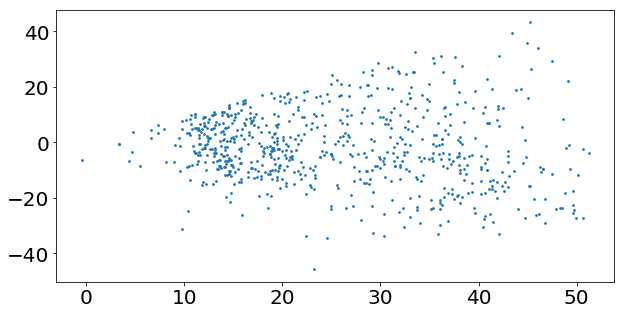

In [139]:
plt.figure(figsize=(10,5))
plt.scatter(model_results.MODEL_PRED, model_results.RESIDUALS, s=3)

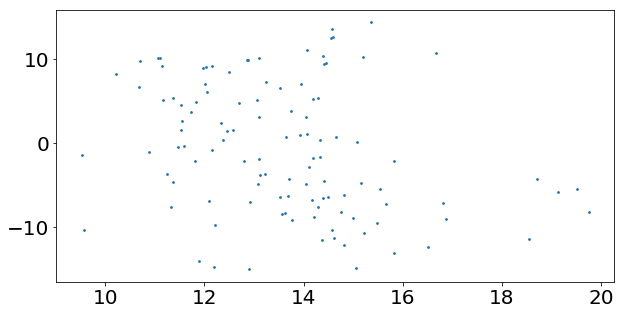

In [140]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_QB.MODEL_PRED, model_results_QB.RESIDUALS, s=3)

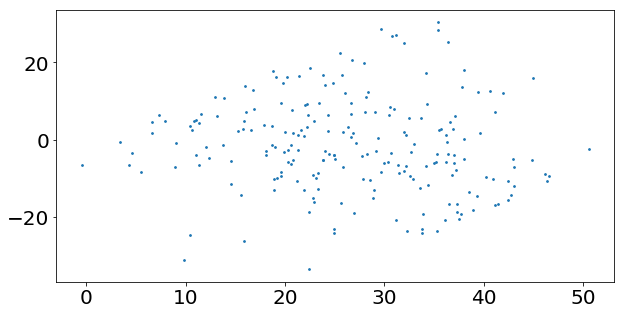

In [141]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_RB.MODEL_PRED, model_results_RB.RESIDUALS, s=3)

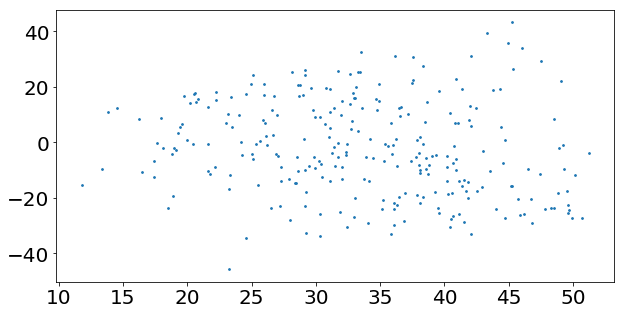

In [142]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_WR.MODEL_PRED, model_results_WR.RESIDUALS, s=3)

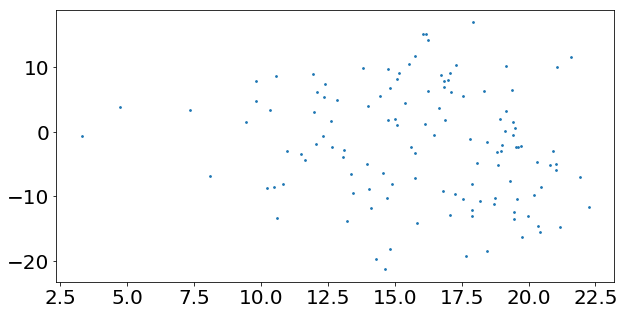

In [143]:
plt.figure(figsize=(10,5))
plt.scatter(model_results_TE.MODEL_PRED, model_results_TE.RESIDUALS, s=3)

-1.68385729853


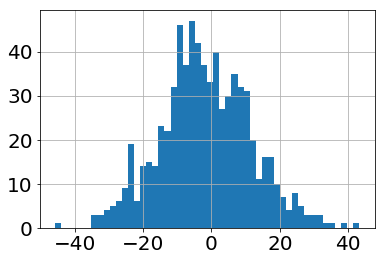

In [144]:
font = {'size'   : 20}
matplotlib.rc('font', **font) 
model_results.RESIDUALS.hist(bins=50)
print(model_results.RESIDUALS.mean())

In [ ]:
matplotlib.rc('font', **font) 
model_results.ESPN_ERROR.hist(bins=50)
print(model_results.ESPN_ERROR.mean())

In [ ]:
# view results

examine = ['full_name','position','team','target_defense','target_week','years_pro','fantasy_points_histmean',
           'fantasy_points_mean','yh_salary','proj_pts','target','LR_PREDICT','LR_ERROR','ESPN_ERROR']

model_results[model_results.target_week==13][examine].sort_values('ESPN_ERROR', ascending=True).head()

In [ ]:
model_results[model_results.target_week==10][examine].sort_values('LR_ERROR', ascending=False).tail()

## holdout test

In [ ]:
def weekly_regression_predict(input_df, weeks, est):
        
    features = input_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    features.remove('target')
    features.remove('target_rank')
    features.remove('target_boxcox')
    features.remove('proj_pts')
    
    train_mse = []
    test_mse = []
    week_nums = []
    y_preds = []
    coefs = []

    for week in weeks:
       
        df_train = input_df[input_df.target_week < week]
        df_test = input_df[input_df.target_week == week]
#         print("Week",week,"Train size:",df_train.shape)
#         print("Week",week,"Test  size:",df_test.shape)
        
        X_train = df_train[features]
        y_train = df_train['target_rank']
        
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.fit_transform(X_test)

        y_pred = est.predict(X_test)
#         score = (metrics.mean_squared_error(y_test, y_pred))**(0.5)
        score = metrics.r2_score(y_test, y_pred)
        test_mse.append(score)
        y_preds.append(y_pred)
        
        if 'sklearn.linear_model' in est.__module__:
            coef_ranks = list(zip(abs(est.coef_), est.coef_, features))
            coef_ranks = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
            coefs.append(coef_ranks)
        else:
            coef_ranks = list(zip(est.feature_importances_, features))
            coef_ranks = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
            coefs.append(coef_ranks)
        
    return week_nums, test_mse, train_mse, y_preds, coefs

In [ ]:
font = {'size'   : 13}
matplotlib.rc('font', **font) 

coefs_all = {}
mses_all = {}
y_preds_all = {}
f, (ax2, ax3, ax4, ax5) = plt.subplots(4,figsize=(12,25), sharex=True)

for pos, data, ax in [('QB',QB_df,ax2),('RB',RB_df,ax3),('WR',WR_df,ax4),('TE',TE_df,ax5)]:
    
    weeks, mses_test, mses_train, y_preds, coefs = weekly_regression_all(data, weeks)
    print("Season-To-Date   MEAN:",np.mean(mses_test))
    print("Season-To-Date MEDIAN:",np.median(mses_test))
    mses_all[pos] = (np.mean(mses_test))
    coefs_all[pos] = coefs
    y_preds_all[pos] = y_preds
    
    ax.plot(weeks, mses_test, label="Test Error", linewidth=4)
    ax.plot(weeks, mses_train, label="Train Error", linewidth=4)
    ax.set_xticks(weeks)
    ax.set_ylabel("RMSE")
    ax.set_title(pos)
    ax.legend()

## weekly regression

In [ ]:
def weekly_regression_all(input_df, weeks):
        
    features = input_df.select_dtypes(include=['float32','int32','int64','float64','uint8']).columns.tolist()
    features.remove('target')
#     features = ['QB','WR','RB','TE','years_pro','age','weight','height','player_weight',
#                 'fantasy_points_mean','target_week','defensive_matchup_allowed']
   
    train_mse = []
    test_mse = []
    week_nums = []
    y_preds = []
    ests = []
    coefs = []

    for week in weeks:
#         est = SVR(kernel='linear',C=10)
#         est = GradientBoostingRegressor(n_estimators=10, learning_rate=0.01)
#         est = RandomForestRegressor(n_estimators=10)
        est = lin.LassoCV()
#         est = XGBRegressor()
                
        df_train = input_df[input_df.target_week < week]
        df_test = input_df[input_df.target_week == week]
#         print("Week",week,"Train size:",df_train.shape)
#         print("Week",week,"Test  size:",df_test.shape)
        
        X_train = df_train[features]
        y_train = df_train['target']
        X_test = df_test[features]
        y_test = df_test['target']
        
        ss = StandardScaler()
        X_train = ss.fit_transform(X_train)
        X_test = ss.fit_transform(X_test)
        
        est.fit(X_train,y_train)
        
        y_pred = est.predict(X_train)
        score = (metrics.mean_squared_error(y_train, y_pred))**(0.5)
        train_mse.append(score)
        
        y_pred = est.predict(X_test)
        score = (metrics.mean_squared_error(y_test, y_pred))**(0.5)
        test_mse.append(score)
        y_preds.append(y_pred)
        
        week_nums.append(week)
        ests.append((week, est))
        
        if 'sklearn.linear_model' in est.__module__:
            coef_ranks = list(zip(abs(est.coef_), est.coef_, features))
            coef_ranks = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
            coefs.append(coef_ranks)
        else:
            coef_ranks = list(zip(est.feature_importances_, features))
            coef_ranks = sorted(coef_ranks, key=lambda x: x[0], reverse=True)
            coefs.append(coef_ranks)
        
    return week_nums, test_mse, train_mse, y_preds, ests, coefs

In [ ]:
font = {'size'   : 13}
matplotlib.rc('font', **font) 

coefs_all = {}
mses_all = {}
y_preds_all = {}
ests_positions = {}
f, (ax2, ax3, ax4, ax5) = plt.subplots(4,figsize=(12,25), sharex=True)

for pos, data, ax in [('QB',QB_df,ax2),('RB',RB_df,ax3),('WR',WR_df,ax4),('TE',TE_df,ax5)]:
    
    weeks, mses_test, mses_train, y_preds, ests, coefs = weekly_regression_all(data, weeks)
    print("STD MEAN:",np.mean(mses_test))
    print("STD MEDIAN:",np.median(mses_test))
    mses_all[pos] = (np.mean(mses_test))
    coefs_all[pos] = coefs
    y_preds_all[pos] = y_preds
    ests_positions[pos] = ests
    ax.plot(weeks, mses_test, label="Test Error", linewidth=4)
    ax.plot(weeks, mses_train, label="Train Error", linewidth=4)
    ax.set_xticks(weeks)
    ax.set_ylabel("RMSE")
    ax.set_title(pos)
    ax.legend()

In [ ]:
pos = 'QB'
for week, c in zip(weeks, coefs_all[pos]):
    print("\nWEEK:",week)
    pprint(c[:4])

In [ ]:
weeks, mses_test, mses_train, y_preds, roto_scores, ests, coefs = weekly_regression_all(model_df, weeks)

print("STD MEAN:",np.mean(mses_test))
print("STD MEDIAN:",np.median(mses_test))
plt.figure(figsize=(25,12))
plt.plot(weeks, mses_test, label="Model Test Error", linewidth=4)
plt.plot(weeks, mses_train, label="Model Train Error", linewidth=4)
# plt.plot(weeks, roto_scores, label="ESPN Error", linestyle='--', linewidth=4)
plt.xticks(weeks)
plt.ylabel("RMSE")
font = {'size'   : 15}
matplotlib.rc('font', **font)    
plt.legend()

In [ ]:
for week, features, mse in zip(weeks, coefs, mses_test):
    print("WEEK:", week, "ERROR:", mse)
    pprint(features[:8])
    print('\n')

## model output

In [ ]:
model_examine_dfs = []
for check_week in weeks:
    model_df_examine = model_df[model_df.target_week == check_week].copy().reset_index()
#     model_df_examine = model_df_examine[~model_df.position.isin(['RB','WR','TE'])]
    model_df_examine.loc[:,'LR_PREDICT'] = pd.Series(y_preds[int(check_week-3)].tolist())
    model_df_examine['LR_ERROR'] = model_df_examine['LR_PREDICT'].sub(model_df_examine['target'], axis=0)
    model_df_examine['ESPN_ERROR'] = model_df_examine['proj_pts'].sub(model_df_examine['target'], axis=0)
    model_df_examine['LR_ABS_ERROR'] = model_df_examine.LR_ERROR.abs()
    model_examine_dfs.append(model_df_examine)
model_results = pd.concat(model_examine_dfs)
model_results.sort_values(['week','position','fantasy_points_mean'],inplace=True)

In [ ]:
liney = np.zeros((250, ))
linex = list(range(250))
plt.figure(figsize=(15,5))
plt.scatter(model_results.index, model_results.LR_ERROR, s=3)
# plt.plot(linex, liney, color='r', linestyle='-', linewidth=3)

In [ ]:
plt.figure(figsize=(15,5))
plt.scatter(model_results.index, model_results.ESPN_ERROR, s=3)
# plt.plot(linex, liney, color='r', linestyle='-', linewidth=3)

In [ ]:
font = {'size'   : 20}
matplotlib.rc('font', **font) 
model_results.LR_ERROR.hist(bins=50)
print(model_results.LR_ERROR.mean())

In [ ]:
matplotlib.rc('font', **font) 
model_results.ESPN_ERROR.hist(bins=50)
print(model_results.ESPN_ERROR.mean())

In [ ]:
# view results

examine = ['full_name','position','team','target_defense','target_week','years_pro','fantasy_points_histmean',
           'fantasy_points_mean','yh_salary','proj_pts','target','LR_PREDICT','LR_ERROR','ESPN_ERROR']

model_results[model_results.target_week==13][examine].sort_values('ESPN_ERROR', ascending=True).head()

In [ ]:
model_results[model_results.target_week==10][examine].sort_values('LR_ERROR', ascending=False).tail()